# Network partitioning - synthetic data
---

## Imports
---

In [1]:
import networkx as nx
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
import os
import math
import pickle
import osmnx as ox
import geopandas as gpd 
import momepy

%matplotlib inline

## Cleaning function

In [2]:
def process_lines_polygons(polygon_data, network_data):
    '''
    reads in:
            - shapefile of polygons
            - shapefile of network
    
    returns dictionary where keys are equal to the shp file name:
            - dataframe of attributes
            - adjacency matrix of network (nodes are equal to X/Y coordinate)
    '''
    
    gdf = polygon_data
    network = network_data
    
    network = network.set_crs('epsg:2039')
    gdf = gdf.to_crs('epsg:2039')
    gdf = gdf.set_index('id')
    
    subgraphs = {}
    for index, polygon in gdf.iterrows():
        clipped = network.clip(polygon['geometry'])
        clipped = clipped[~clipped.is_empty]    
        subgraphs[index] = clipped
    
    subgraphs_nx = {}
    for i in subgraphs:
        subgraphs_nx[i] = momepy.gdf_to_nx(subgraphs[i], approach="primal")
        
    sub_graphs_dict = {}
    for key, value in subgraphs_nx.items():
        sub_graphs_dict[key] = pd.DataFrame(nx.adjacency_matrix(subgraphs_nx[key], nodelist=sorted(subgraphs_nx[key].nodes())).todense(), 
                 index = sorted(subgraphs_nx[key].nodes()),
                columns = sorted(subgraphs_nx[key].nodes()))
    
    return(gdf, sub_graphs_dict)

## Data
---

In [3]:
gdf = gpd.read_file("shp_files/polygons/polygon_merged_2.shp")

In [8]:
#ofer_network = gpd.read_file("shp_files/StreetNetwork")

In [4]:
directory = 'shp_files'

dicty = {}

for folder in os.listdir(directory):
    if folder == 'polygons':
        continue
    else:    
        shp = os.path.join(directory, folder).replace("\\","/")
        print(shp)
        network = gpd.read_file(shp)
        dicty[folder] = process_lines_polygons(gdf, network)

shp_files/StreetNetwork


In [5]:
dicty.keys()

dict_keys(['StreetNetwork'])

In [9]:
dicty['StreetNetwork'][1][1].head(2)

,"(178520.7235365087, 663103.9268812288)","(178523.2820860721, 663019.4977763685)","(178526.26780749662, 662920.972506099)","(178528.83478324552, 662836.2653470986)","(178531.90869983568, 662734.8297408329)","(178535.12915727793, 662628.5584600348)","(178540.1431173969, 662463.1037153993)","(178551.0883840486, 663106.8940703003)","(178555.24835110197, 663122.1087628714)","(178568.243822847, 663024.3532766422)",...,"(178932.00914865665, 662479.451756953)","(178950.484529172, 662636.531335858)","(178956.6097675703, 662968.5702305032)","(178978.1747814609, 663039.5419759592)","(178991.47668675464, 663104.3969367769)","(179022.72296005208, 662673.8242697803)","(179076.70704937892, 663129.3386879673)","(179091.23108425358, 662809.5218262211)","(179167.2839934806, 662943.8217018828)","(179209.50852678617, 663031.1102697516)"
"(178520.7235365087, 663103.9268812288)",0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"(178523.2820860721, 663019.4977763685)",0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
dicty['StreetNetwork'][1][2].head(2)

,"(177860.6122030813, 662821.6432968262)","(177898.71939870354, 662738.1300921106)","(177914.2213470644, 662735.1040344888)","(177921.0948698273, 662753.3269029348)","(177931.32295305957, 662862.4357922911)","(177931.3541882501, 662659.4215335724)","(177947.46729710387, 662569.8473603032)","(177956.366399838, 662732.0021013496)","(177964.7275672707, 662804.2229362131)","(178001.17459975672, 662903.1466933412)",...,"(178502.57219849905, 662741.7499150727)","(178504.67561476567, 662838.0809931211)","(178504.7455907356, 662837.3255098012)","(178520.7235365087, 663103.9268812288)","(178523.2820860721, 663019.4977763685)","(178526.26780749662, 662920.972506099)","(178528.83478324552, 662836.2653470986)","(178531.90869983568, 662734.8297408329)","(178535.12915727793, 662628.5584600348)","(178540.1431173969, 662463.1037153993)"
"(177860.6122030813, 662821.6432968262)",0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(177898.71939870354, 662738.1300921106)",0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

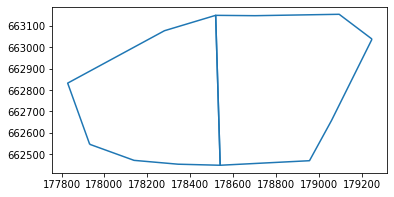

In [8]:
dicty['StreetNetwork'][0].boundary.plot()

In [11]:
pickle.dump(dicty, open("pickle/dicty.p", "wb"))

In [12]:
graphs_dict = pickle.load(open("pickle/dicty.p", "rb"))